# Apply AI Superresolution to video - Train VDSR from Video Frames



 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- 

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- different blur levels
- convolution with disk
- left-right flip - complete
- contrast and brightness - complete
- random crop
- crop to the super8 resolution 720x480 or video 320x240
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring

## Optimization
- Use Adam
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this

## losses
- try l1 loss
- try perceptive loss vgg18

## do comparisons for standard test sets



In [ ]:
# preprocess video from wmv to mp4

In [ ]:
#!ffmpeg -i '/home/filip/Videos/1987 first video making muffins.wmv'  -c:v libx264 -crf 23 -c:a aac -strict -2 -q:a 100 '/media/SSD/superres/1987 first video making muffins.mp4'

In [ ]:
#!python /media/SSD/superres/Zooming-Slow-Mo-CVPR-2020/codes/video_to_zsm.py --video /media/SSD/superres/snip.mp4  --model /media/SSD/superres/model/xiang2020zooming.pth --output /media/SSD/superres/muffins_test.mp4


Traceback (most recent call last):
  File "/media/SSD/superres/Zooming-Slow-Mo-CVPR-2020/codes/models/modules/Sakuya_arch.py", line 9, in <module>
    from models.modules.DCNv2.dcn_v2 import DCN_sep
  File "/media/SSD/superres/Zooming-Slow-Mo-CVPR-2020/codes/models/modules/DCNv2/dcn_v2.py", line 11, in <module>
    import _ext as _backend
ImportError: /media/SSD/superres/Zooming-Slow-Mo-CVPR-2020/codes/models/modules/DCNv2/_ext.cpython-38-x86_64-linux-gnu.so: undefined symbol: _ZN6caffe28TypeMeta21_typeMetaDataInstanceISt7complexIdEEEPKNS_6detail12TypeMetaDataEv

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/media/SSD/superres/Zooming-Slow-Mo-CVPR-2020/codes/video_to_zsm.py", line 12, in <module>
    import models.modules.Sakuya_arch as Sakuya_arch
  File "/media/SSD/superres/Zooming-Slow-Mo-CVPR-2020/codes/models/modules/Sakuya_arch.py", line 11, in <module>
    raise ImportError('Failed to import DCNv2 module.')
Impor

In [ ]:
#preprocess from mpeg2 (DVD) to mp4 with antialiasing and only 120 seconds:
#ffmpeg -i 'Old 8mm Reels_1.VOB' -t 120  -vf "bwdif" -c:v libx264 -crf 28 -c:a aac -b:a 128k  'Old 8mm Reels_1.mp4'

In [ ]:
!pwd

To deinterlace
https://video.stackexchange.com/questions/17396/how-to-deinterlacing-with-ffmpeg
https://macilatthefront.blogspot.com/2017/04/deinterlacing-hd-footage-without-losing.html


In [1]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import os
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')
#import vdsr
from vdsr import Net

In [2]:
torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [3]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [4]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision


toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    return img


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x)
                                for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)
    
    


In [5]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)


def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                # calculate middle of video and take 'frame_sample_size' frames from middle
                middle = length // 2
                left_length = frame_sample_size//2
                right_length = frame_sample_size - left_length
                left = max(0,middle - left_length)
                right = min(length, middle + right_length)
                # append fn and frame num to instances
            else:
                left = 0
                right = length
                
            for frame in range(left,right):
                item = filepath, frame
                instances.append(item)
        
    return instances
        

In [21]:
instances = make_framelist("/media/SSD/superres/video_data")

In [ ]:
#instances

In [32]:
def load_frame(video_frame):
    
    path, frame = video_frame
    cap = cv2.VideoCapture(str(path))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
    ret, img = cap.read()
    if ret==0:
        print(video_frame)
    #im_b_ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    im_b_ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_b_ycbcr)

In [33]:
from torchvision.transforms import RandomHorizontalFlip,ColorJitter

class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.1, contrast=.1)(input)
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [34]:
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

In [ ]:
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel

def bokah(img, z1,z2,g_val):
    def gamma(im,g):
        lookUpTable = np.empty((1,256), np.uint8)
        for i in range(256):
            lookUpTable[0,i] = np.clip(pow(i / 255.0, g) * 255.0, 0, 255)
        return cv2.LUT(im.astype(np.uint8), lookUpTable)

        
    #gamma correct
    imgb = gamma(img,g_val)
    imgb = cv2.filter2D(imgb, -1, Tophat2DKernel(z1).array)
    imgb = gamma(imgb,1/g_val)
    img = cv2.filter2D(img, -1, Tophat2DKernel(z2).array)
    
    img=cv2.max(img, imgb)
    #img = imgb
    return img
    

In [ ]:
plt.imshow(bokah(np.array(im_gt), 8,2,3))

In [ ]:
plt.imshow(np.array(im_gt))

In [ ]:
im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))

im_gt_y = im_gt_ycbcr[:,:,0].astype(float)

In [ ]:
plt.imshow((im_gt_y),cmap='gray')

In [ ]:
sm = convolve(im_gt_y, AiryDisk2DKernel(20))
plt.imshow((sm),cmap='gray')

In [ ]:
sm = cv2.filter2D(im_gt_y, -1, AiryDisk2DKernel(10).array)

plt.imshow((sm),cmap='gray')

In [ ]:
plt.imshow(Tophat2DKernel(10).array)

In [13]:
import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel

class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        self.crop_size = crop_size
        self.factor_range = factor_range

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        # Crop to final size
        
        
        #Gaussian Blur (bad result)
        #img = Resize((int(self.crop_size/rand_scale_factor), int(self.crop_size/rand_scale_factor)), Image.BICUBIC)(img)
        #img = Resize((self.crop_size, self.crop_size), Image.BICUBIC)(img)
        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img = cv2.filter2D(np.array(img), -1, Tophat2DKernel(rand_scale_factor).array)
    
        img= Image.fromarray(img)
        
        img = CenterCrop(self.crop_size)(img)
        #print("size after center crop",img.size)
        
        
        return img

(1920, 1080) (512, 512)


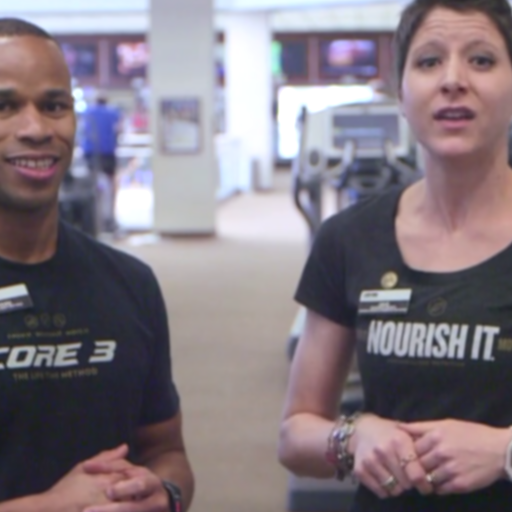

In [46]:
#test the CropRescale transform
im=load_frame(instances[100])
#im = Grayscale(num_output_channels=1)(im)
im_res = CropRescale(crop_size = 512, factor_range=(2,2))(im)
print(im_gt.size,im_res.size)
type(im_res)
im_res

(1920, 1080) (512, 512)


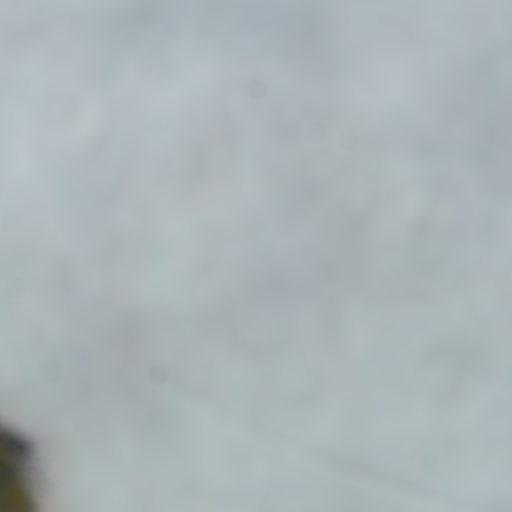

In [15]:
im_gt = Image.open("/home/filip/Pictures/Screenshot from CADDX000009.MP4.png").convert("RGB")
im_res = CropRescale(crop_size = 512, factor_range=(10,10))(im_gt)
print(im_gt.size,im_res.size)
type(im_res)
im_res

In [47]:





def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def input_transform_old(crop_size, upscale_factor):
    
    
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        Resize((crop_size//upscale_factor, crop_size//upscale_factor), Image.BICUBIC),
        Resize((crop_size, crop_size), Image.BICUBIC), 
        ToTensor(),
    ])

def input_transform(crop_size, factor_range):
    
    
    return Compose([
        Grayscale(num_output_channels=1),
        CropRescale(crop_size,factor_range), 
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(data_dir, crop_size, upscale_factor, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    
    #cropsize = calculate_valid_crop_size(crop_size, upscale_factor)
    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, upscale_factor),
                             target_transform=target_transform(cropsize),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


def get_validation_set(data_dir, crop_size, upscale_factor):
    
    cropsize = calculate_valid_crop_size(crop_size, upscale_factor)

    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, upscale_factor,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, upscale_factor):

    cropsize = calculate_valid_crop_size(crop_size, upscale_factor)

    return DatasetFromVideoFolder(data_dir,frame_sample_size=None,
                             input_transform=input_transform(
                                 cropsize, upscale_factor),
                             target_transform=target_transform(cropsize))

In [48]:
train_dir = "/media/SSD/superres/video_data"

In [49]:
train_set = get_training_set(data_dir=train_dir, crop_size=512,
            upscale_factor=(4,4),frame_sample_size =10, add_noise=False, noise_std=3.0,
                             Flip_hor=False,Rand_bright_contrast=False)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=4, shuffle=True)

512


In [50]:
import matplotlib.pyplot as plt
def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

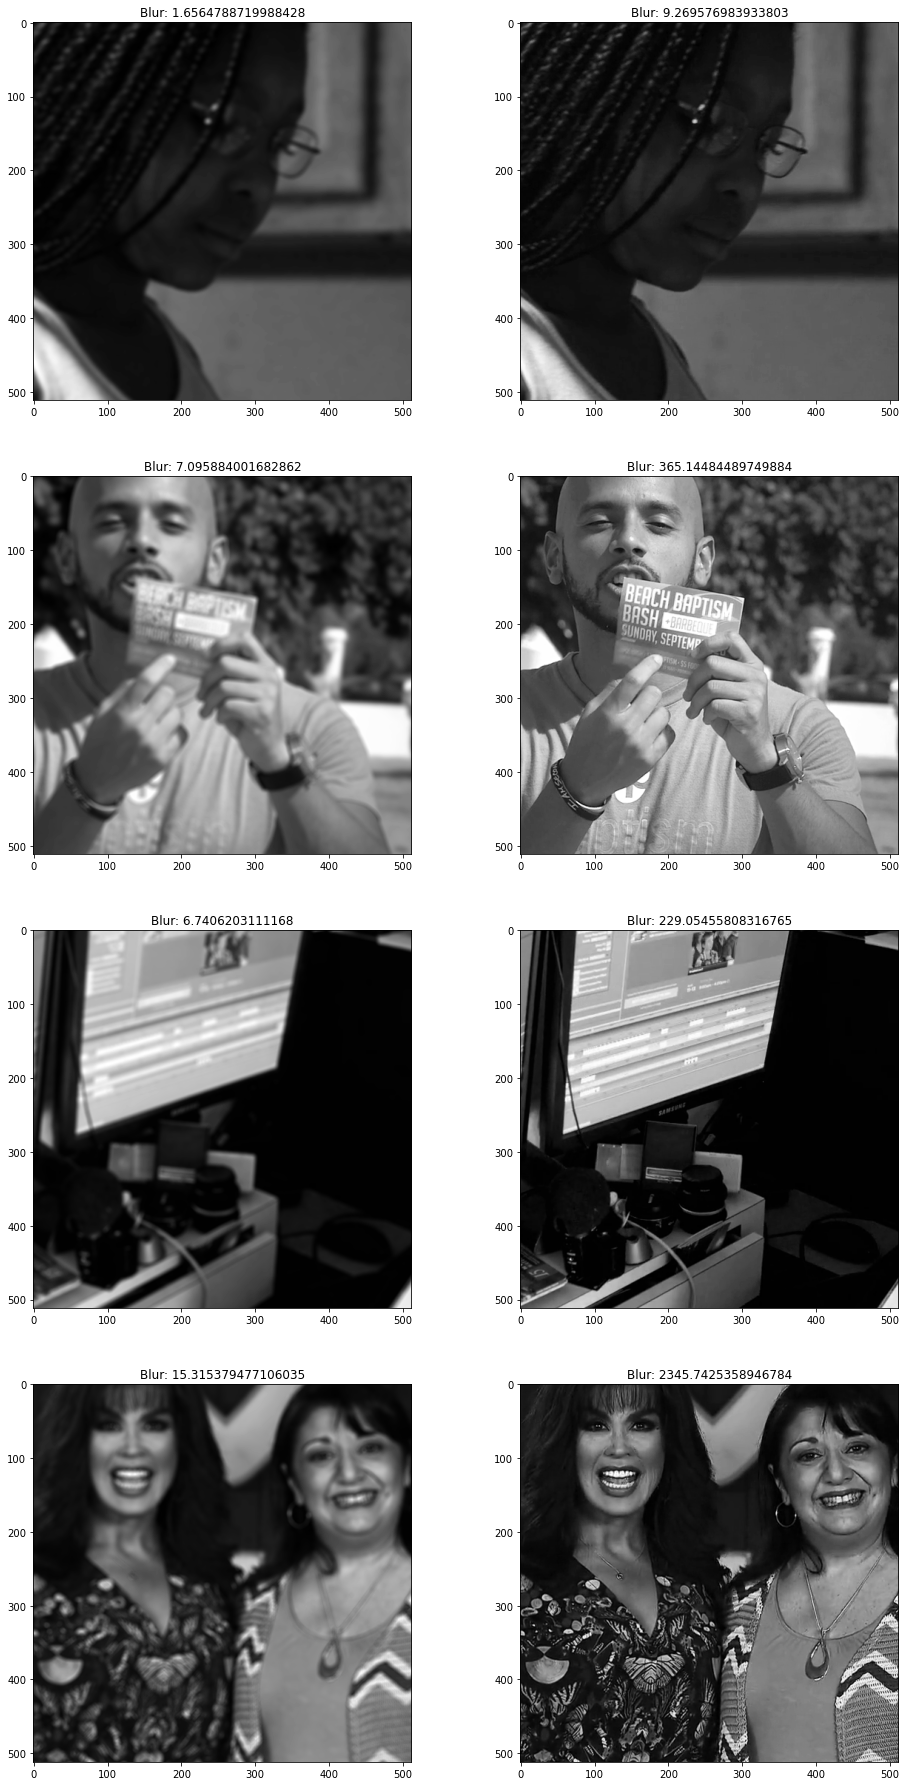

In [51]:
show_batch(training_data_loader,size =8)

In [ ]:
inputs, outputs = next(iter(training_data_loader))

In [ ]:
inputs[0].shape, outputs[0].shape

# Test Dataloader (had bad frames)

In [ ]:
#make framelist
fl = make_framelist(train_dir)

In [ ]:
fl[0]

In [ ]:
from tqdm import tqdm

In [ ]:
for data in tqdm(iter(training_data_loader)):
    input, output = data

    
    

Build the model

In [ ]:
#model = Net()
criterion = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1oss(reduction = 'sum')

In [ ]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]

In [ ]:
init_lr = 0.1
lr_step = 5
gradient_clip = 0.4

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 10 epochs"""
    lr = init_lr * (0.1 ** (epoch // lr_step))
    return lr

In [ ]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "model3_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
import datetime

In [ ]:
def train(training_data_loader, optimizer, model, criterion, epoch):
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()

        loss = criterion(model(input), target)
        optimizer.zero_grad()
        loss.backward() 
        nn.utils.clip_grad_norm(model.parameters(),gradient_clip) 
        optimizer.step()

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), loss.data))

In [ ]:
for epoch in range(1, 3):
        train(training_data_loader, optimizer, model, criterion, epoch)
        save_checkpoint(model, epoch)

In [ ]:
print(model)

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [ ]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [ ]:
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [ ]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

# compare to benchmarks

In [ ]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [ ]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [ ]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [ ]:
def display_PSNR(im_gt, im_b, model):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    print('psnr for bicubic is {}dB'.format(psnr_bicubic))
    
    # Prepare for the input, a pytorch tensor
    im_input = im_b_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    print('psnr for vdsr is {}dB'.format(psnr_predicted))
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    print("Sharpness Measurement GroundTruth:",blur_measure_gt)
    print("Sharpness Measurement Input:",blur_measure_input)
    print("Sharpness Measurement VDSR:",blur_measure_vdsr)
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    
    # Result visualization
    fig = plt.figure(figsize=(18, 16), dpi= 80)
    ax = plt.subplot("131")
    ax.imshow(im_gt)
    ax.set_title("GT")

    ax = plt.subplot("132")
    ax.imshow(im_b)
    ax.set_title("Input(bicubic)")

    ax = plt.subplot("133")
    ax.imshow(im_h)
    ax.set_title("Output(vdsr)")
    plt.show()
    
    return psnr_bicubic, psnr_predicted

In [ ]:
model = torch.load("/media/SSD/superres/checkpoint/model3_epoch_2.pth")["model"]

In [ ]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")

In [ ]:
display_PSNR(im_gt, im_b, model)

# convert sample videos

In [ ]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = "/media/SSD/superres/super8test4.mp4"
error_file = "/media/SSD/superres/error.txt"

In [ ]:
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = "/media/SSD/superres/muffins30sectest4.mp4"
superres_mp4(infile, outfile, model, factor=1.6,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = "/media/SSD/superres/muffins30sectest4-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = "/media/SSD/superres/muffins30sectest4-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

In [ ]:
from multiprocessing.pool import ThreadPool
from collections import deque


def superres_parallel_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):

    class DummyTask:
        def __init__(self, data):
            self.data = data
        def ready(self):
            return True
        def get(self):
            return self.data





    
    
    model = model.cpu()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',
torc
            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)   
    
    
 
    def process_frame(frame, t0):
        
        if (factor != 1.0):
            frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
        im_b_y = im_b_ycbcr[:,:,0].astype(float)
        im_input = im_b_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
        #im_input = im_input.cuda()
        out = model(im_input)

        #out = out.cpu()
        im_h_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_h_y * 255.
        im_h_y[im_h_y < 0] = 0
        im_h_y[im_h_y > 255.] = 255.
        im_h_y = im_h_y[0,:,:]

        im_h = colorize(im_h_y, im_b_ycbcr)        
        
        
        return im_h, t0

    
    
    
    threadn = cv2.getNumberOfCPUs()
    pool = ThreadPool(processes = threadn)
    pending = deque()

    threaded_mode = True

    
    while True:
        while len(pending) > 0 and pending[0].ready():
            res, t0 = pending.popleft().get()
            p.stdin.write(res.tobytes())
            
            
            cv2.imshow('threaded video', res)
        if len(pending) < threadn:
            _ret, frame = cap.read()
            t = 0
            
            last_frame_time = t
            if threaded_mode:
                task = pool.apply_async(process_frame, (frame.copy(), t))
            else:
                task = DummyTask(process_frame(frame, t))
            pending.append(task)
        ch = cv2.waitKey(1)
        if ch == ord(' '):
            threaded_mode = not threaded_mode
        if ch == 27:
            break

    print('Done')
    
    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()



In [ ]:
superres_parallel_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
model

In [ ]:
infolder = Path("to_do_videos")
outfolder = Path("undistorted_videos")
completefolder = Path("raw_videos")

outfolder.mkdir(exist_ok=True)
completefolder.mkdir(exist_ok=True)


In [ ]:
for filename in infolder.iterdir():
    

    undistort_outfile = outfolder/("undistort"+filename.name)
    
    retval = undistort_mp4(infile=filename, outfile=undistort_outfile,
                           intrinsic_matrix=im, distortion_coefficients=dc,
                           crop=True,display=False,bitrate= "12000k",errorfile = None)   
    
    if retval:
        #move the source file if successful
        completefile = completefolder/filename.name
        filename.rename(completefile)